In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import LinearSVC, SVC, OneClassSVM

In [4]:
file = pd.read_csv(r'Dataset/Dataset_13.05.2020_11.18am_1.csv')
tweets = np.asarray(file['Tweet'].copy())
targets = np.asarray(file['Is_Unreliable'].copy())
tweet_embeddings = np.load(r'Dataset/Tweet_Embeddings_Word2Vec_13.05.2020_2.41pm_1.npy', allow_pickle=True)
print(tweet_embeddings.shape)
print(tweet_embeddings[0].shape)
X = list()
for tweet in tweet_embeddings:
    embeddings = np.mean(tweet, axis=0, dtype=np.float64)
    X.append(embeddings)
X = np.asarray(X)
print(X.shape)
print(X.dtype)

y = targets
print(y.shape)
print(y.dtype)

(560,)
(15, 300)
(560, 300)
float64
(560,)
int64


In [189]:
# print(y)
# y[y == 1] = -1
# y[y == 0] = 1
# y[y == -1] = 0
# print(y)

In [105]:
class AE(nn.Module):

    def __init__(self, hidden_size=100):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(300, hidden_size)  # 6*6 from image dimension
        self.fc2 = nn.Linear(hidden_size, 300)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# net = AE()
# print(net)

def train_AE(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False, print_interval=100):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in tqdm(range(epochs)):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
#         print(X_train)
#         print(output)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if to_print and epoch%print_interval == 0:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train - train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1] - test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0] - test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
#         print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

def train_AE_wo_tqdm(model, X_train, y_train, X_test, y_test, epochs=100, to_print=False, print_interval=100):
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    
    train_mse_list, test_1_mse_list, test_0_mse_list = list(), list(), list()
    # enumerate epochs
    for epoch in range(epochs):
        # clear the gradients
        optimizer.zero_grad()
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        output = model(X_train)
#         print(X_train)
#         print(output)
        train_loss = criterion(output, X_train)
        train_loss.backward()
        optimizer.step()
        if to_print and epoch%print_interval == 0:
            print("epoch : {}/{}, train_loss = {:.6f}".format(epoch + 1, epochs, train_loss))
        
        train_preds = model(X_train)
        X_train = X_train.numpy()
        train_preds = train_preds.detach().numpy()
        test_preds = model(X_test)
        X_test = X_test.numpy()
        test_preds = test_preds.detach().numpy()
        train_mse = np.mean(np.square(X_train - train_preds), axis=1)
        test_1_mse = np.mean(np.square(X_test[y_test == 1] - test_preds[y_test == 1]), axis=1)
        test_0_mse = np.mean(np.square(X_test[y_test == 0] - test_preds[y_test == 0]), axis=1)
        train_mse_list.append(train_mse), test_1_mse_list.append(test_1_mse), test_0_mse_list.append(test_0_mse)
#         print('Train:', train_mse, ' Test (1_class):', test_1_mse, ' Test (0_class):', test_0_mse)
        
    return model, (train_mse_list, test_1_mse_list, test_0_mse_list)

def predict_AE(model, X_train, X_test, threshold, above_thres_class=0):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train - train_out), axis=1)
    test_mse = np.mean(np.square(X_test - test_out), axis=1)
    
    train_preds, test_preds = np.empty((train_mse.shape[0])), np.empty((test_mse.shape[0]))
    train_preds[train_mse > threshold] = above_thres_class
    train_preds[train_mse <= threshold] = (above_thres_class+1)%2
    test_preds[test_mse > threshold] = above_thres_class
    test_preds[test_mse <= threshold] = (above_thres_class+1)%2
        
    return (train_preds, test_preds)

def predict_AE_for_ROC(model, X_train, X_test):
    
    X_train = torch.from_numpy(X_train).float()
    X_test = torch.from_numpy(X_test).float()
    train_out = model(X_train)
    X_train = X_train.numpy()
    train_out = train_out.detach().numpy()
    test_out = model(X_test)
    X_test = X_test.numpy()
    test_out = test_out.detach().numpy()
    train_mse = np.mean(np.square(X_train - train_out), axis=1)
    test_mse = np.mean(np.square(X_test - test_out), axis=1)
    
    return (train_mse, test_mse)

In [110]:
# from scipy import stats

# stats.describe(X)

In [154]:
# model = AE()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer.zero_grad()
# X_trial = X.copy()
# X_trial = torch.from_numpy(X_trial).float()
# output = model(X_trial)
# output = output.detach().numpy()

# stats.describe(output)

In [161]:
# np.square(X_trial[0] - output[0])
# output[0]
# X_trial[0]

In [6]:
percent = 0.9

X_0, X_1_, y_0, y_1_ = X[y==0].copy(), X[y==1].copy(), y[y==0].copy(), y[y==1].copy()
X_1, _, y_1, _ = train_test_split(X_1_, y_1_, train_size=percent, shuffle=True, random_state=0)

X_train, X_test_, y_train, y_test_ = train_test_split(X_0, y_0, train_size = 0.67, shuffle=True, random_state=0)
X_test, y_test = np.concatenate((X_1.copy(), X_test_.copy())), np.concatenate((y_1.copy(), y_test_.copy()))
X_test, y_test = shuffle(X_test, y_test, random_state=0)

# y_train[y_train == 1] = -1
# y_train[y_train == 0] = 1
# y_train[y_train == -1] = 0
# y_test[y_test == 1] = -1
# y_test[y_test == 0] = 1
# y_test[y_test == -1] = 0

print(X_train.shape, y_train.shape, sum(y_train))
print(X_test.shape, y_test.shape, sum(y_test))

(187, 300) (187,) 0
(345, 300) (345,) 252


In [7]:
clf = OneClassSVM(nu=len(y_1)/len(y_0))
clf.fit(X_train)
c_train_preds = clf.predict(X_train)
c_test_preds = clf.predict(X_test)

c_train_preds[c_train_preds == 1] = 0
c_train_preds[c_train_preds == -1] = 1
c_test_preds[c_test_preds == 1] = 0
c_test_preds[c_test_preds == -1] = 1

# c_train_preds[c_train_preds == -1] = 0
# c_test_preds[c_test_preds == -1] = 0

print('Fit status:', clf.fit_status_) # 0 if correctly fitted 
print('')
print('Acc:', accuracy_score(y_test, c_test_preds))
print('F1 :', f1_score(y_test, c_test_preds, average='weighted'))
print('P  :', precision_score(y_test, c_test_preds, average='weighted'))
print('R  :', recall_score(y_test, c_test_preds, average='weighted'))
# print('ROC:', roc_auc_score(y_test, c_test_preds)) #Should be used with probability values
print('\nConfusion Matrix')
print(confusion_matrix(y_test, c_test_preds))

# clf_test_vals = clf.decision_function(X_test)

# print(clf_test_vals)

Fit status: 0

Acc: 0.6550724637681159
F1 : 0.6141672100817397
P  : 0.5905412823891085
R  : 0.6550724637681159

Confusion Matrix
[[ 11  82]
 [ 37 215]]


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(hidden_size=100).to(device)
# print(model)
n_epochs = 100
model, _ = train_AE(model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)

best_f = 0
train_preds, test_preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
for th in np.arange(0.0001, 0.0100, 0.0001):
    (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
    if (f1_score(y_test, te_preds, average='weighted') > best_f):
        best_f = f1_score(y_test, te_preds, average='weighted')
        train_preds = tr_preds
        test_preds = te_preds

print('Acc:', accuracy_score(y_test, test_preds))
print('F1 :', f1_score(y_test, test_preds, average='weighted'))
print('P  :', precision_score(y_test, test_preds, average='weighted'))
print('R  :', recall_score(y_test, test_preds, average='weighted'))
# print('ROC:', roc_auc_score(y_test, test_preds)) #Should be used with probability values
print('\nConfusion Matrix')
print(confusion_matrix(y_test, test_preds))

100%|██████████| 100/100 [00:01<00:00, 82.07it/s]


Acc: 0.7072463768115942
F1 : 0.6725284724223168
P  : 0.6632191480017567
R  : 0.7072463768115942

Confusion Matrix
[[ 20  73]
 [ 28 224]]


In [11]:
print('Acc:', accuracy_score(y_test, c_test_preds))
print('F1 :', f1_score(y_test, c_test_preds, average='weighted'))
print('P  :', precision_score(y_test, c_test_preds, average='weighted'))
print('R  :', recall_score(y_test, c_test_preds, average='weighted'))
# print('ROC:', roc_auc_score(y_test, c_test_preds)) #Should be used with probability values
print('\nConfusion Matrix')
print(confusion_matrix(y_test, c_test_preds))

print()
print('Acc:', accuracy_score(y_test, test_preds))
print('F1 :', f1_score(y_test, test_preds, average='weighted'))
print('P  :', precision_score(y_test, test_preds, average='weighted'))
print('R  :', recall_score(y_test, test_preds, average='weighted'))
# print('ROC:', roc_auc_score(y_test, test_preds)) #Should be used with probability values
print('\nConfusion Matrix')
print(confusion_matrix(y_test, test_preds))

Acc: 0.6550724637681159
F1 : 0.6141672100817397
P  : 0.5905412823891085
R  : 0.6550724637681159

Confusion Matrix
[[ 11  82]
 [ 37 215]]

Acc: 0.7072463768115942
F1 : 0.6725284724223168
P  : 0.6632191480017567
R  : 0.7072463768115942

Confusion Matrix
[[ 20  73]
 [ 28 224]]


In [207]:
# (train_mse, test_mse) = predict_AE_for_ROC(model, X_train, X_test)

# print(min(train_mse), max(train_mse))
# print(min(test_mse), max(test_mse))

# print(test_mse.shape)

# test_mse_sorted_idx = np.argsort(test_mse)

# # test_mse[test_mse_sorted_idx]

# for i in np.arange(test_mse.shape[0])[-1:-3:-1]:
#     th = test_mse[test_mse_sorted_idx][i]
# #     print(th)
#     test_preds_for_ROC = (test_mse >= th).astype(int)
# #     print(test_preds_for_ROC)
#     cm = confusion_matrix(y_test, test_preds_for_ROC)
#     print(cm)
# #     print(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

In [239]:
# (train_mse, test_mse) = predict_AE_for_ROC(model, X_train, X_test)
# fpr_AE, tpr_AE, thresholds_AE = roc_curve(y_test, test_mse, pos_label=1)
# roc_auc_AE = auc(fpr_AE, tpr_AE)
# # print(tpr_AE)
# # print(fpr_AE)
# # print(thresholds_AE)

# plt.figure()
# plt.plot(fpr_AE, tpr_AE, color='darkorange', lw=2, label='ROC curve AE (area = %0.2f)' % roc_auc_AE)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

In [231]:
# clf_train_vals, clf_test_vals = clf.decision_function(X_train), clf.decision_function(X_test)
# clf_test_vals = (max(clf_test_vals) - clf_test_vals)

# clf_test_vals_sorted_idx = np.argsort(clf_test_vals)

# # clf_test_vals[clf_test_vals_sorted_idx]

# for i in np.arange(clf_test_vals.shape[0])[-1:-3:-1]:
#     th = clf_test_vals[clf_test_vals_sorted_idx][i]
# #     print(th)
#     c_test_preds_for_ROC = (clf_test_vals >= th).astype(int)
# #     print(c_test_preds_for_ROC)
#     cm = confusion_matrix(y_test, c_test_preds_for_ROC)
#     print(cm)
# #     print(cm[0][0], cm[0][1], cm[1][0], cm[1][1])

In [238]:
# clf_train_vals, clf_test_vals = clf.decision_function(X_train), clf.decision_function(X_test)
# fpr_c, tpr_c, thresholds_c = roc_curve(y_test, (max(clf_test_vals) - clf_test_vals), pos_label=1)
# roc_auc_c = auc(fpr_c, tpr_c)
# # print(tpr_c)
# # print(fpr_c)
# # print(thresholds_c)

# plt.figure()
# plt.plot(fpr_c, tpr_c, color='darkorange', lw=2, label='ROC curve OC-SVM (area = %0.2f)' % roc_auc_c)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

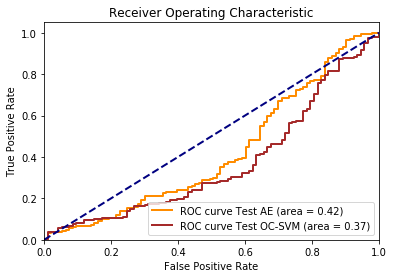

In [14]:
(train_mse, test_mse) = predict_AE_for_ROC(model, X_train, X_test)
# fpr_AE, tpr_AE, thresholds_AE = roc_curve(y_test, test_mse, pos_label=1)
# roc_auc_AE = auc(fpr_AE, tpr_AE)
# print(tpr_AE)
# print(fpr_AE)
# print(thresholds_AE)
fpr_AE_t, tpr_AE_t, thresholds_AE_t = roc_curve(y_train, train_mse, pos_label=1)
roc_auc_AE_t = auc(fpr_AE_t, tpr_AE_t)

clf_train_vals, clf_test_vals = clf.decision_function(X_train), clf.decision_function(X_test)
fpr_c, tpr_c, thresholds_c = roc_curve(y_test, (max(clf_test_vals) - clf_test_vals), pos_label=1)
roc_auc_c = auc(fpr_c, tpr_c)
# fpr_c_t, tpr_c_t, thresholds_c_t = roc_curve(y_train, (max(clf_train_vals) - clf_train_vals), pos_label=1)
# roc_auc_c_t = auc(fpr_c_t, tpr_c_t)
# print(tpr_c)
# print(fpr_c)
# print(thresholds_c)

plt.figure()
plt.plot(fpr_AE, tpr_AE, color='darkorange', lw=2, label='ROC curve Test AE (area = %0.2f)' % roc_auc_AE)
plt.plot(fpr_c, tpr_c, color='brown', lw=2, label='ROC curve Test OC-SVM (area = %0.2f)' % roc_auc_c)
# plt.plot(fpr_AE_t, tpr_AE_t, color='yellow', lw=2, label='ROC curve Train AE (area = %0.2f)' % roc_auc_AE_t)
# plt.plot(fpr_c_t, tpr_c_t, color='pink', lw=2, label='ROC curve Train OC-SVM (area = %0.2f)' % roc_auc_c_t)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [235]:
# roc_auc_score(y_test, test_mse)

0.42008021846731525

In [66]:
# sum(test_preds[y_test==1]==0)

43

In [ ]:
# Autoencoder and OC-SVM on class=0 as training data (class=0 has NOT been changed to class=1)

for percent in np.arange(0.9, 0.01, -0.1):
    X_0, X_1_, y_0, y_1_ = X[y==0].copy(), X[y==1].copy(), y[y==0].copy(), y[y==1].copy()
    X_1, _, y_1, _ = train_test_split(X_1_, y_1_, train_size=percent, shuffle=True, random_state=0)

    X_train, X_test_, y_train, y_test_ = train_test_split(X_0, y_0, train_size = 0.67, shuffle=True, random_state=0)
    X_test, y_test = np.concatenate((X_1.copy(), X_test_.copy())), np.concatenate((y_1.copy(), y_test_.copy()))
    X_test, y_test = shuffle(X_test, y_test, random_state=0)

    # y_train[y_train == 1] = -1
    # y_train[y_train == 0] = 1
    # y_train[y_train == -1] = 0
    # y_test[y_test == 1] = -1
    # y_test[y_test == 0] = 1
    # y_test[y_test == -1] = 0

#     print(X_train.shape, y_train.shape, sum(y_train))
#     print(X_test.shape, y_test.shape, sum(y_test))
    
    clf = OneClassSVM(nu=len(y_1)/len(y_0))
    best_roc_auc = 0
    for kl in tqdm(('linear', 'poly', 'rbf', 'sigmoid')):
        for gm in ('auto', 'scale', 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001):
            this_clf = OneClassSVM(kernel=kl, gamma=gm, nu=len(y_1)/len(y_0))
            this_clf.fit(X_train)
            clf_test_vals = this_clf.decision_function(X_test)
            roc_auc_till_now = roc_auc_score(y_test, (max(clf_test_vals) - clf_test_vals))
            if ((roc_auc_till_now > best_roc_auc) and (this_clf.fit_status_ == 0)):
                best_roc_auc = roc_auc_till_now
                clf = this_clf
                
            
    clf.fit(X_train)
    c_train_preds = clf.predict(X_train)
    c_test_preds = clf.predict(X_test)

    c_train_preds[c_train_preds == 1] = 0
    c_train_preds[c_train_preds == -1] = 1
    c_test_preds[c_test_preds == 1] = 0
    c_test_preds[c_test_preds == -1] = 1

    # c_train_preds[c_train_preds == -1] = 0
    # c_test_preds[c_test_preds == -1] = 0

#     print('Fit status:', clf.fit_status_) # 0 if correctly fitted 
#     print('')
#     print('Acc:', accuracy_score(y_test, c_test_preds))
#     print('F1 :', f1_score(y_test, c_test_preds, average='weighted'))
#     print('P  :', precision_score(y_test, c_test_preds, average='weighted'))
#     print('R  :', recall_score(y_test, c_test_preds, average='weighted'))
#     # print('ROC:', roc_auc_score(y_test, c_test_preds)) #Should be used with probability values
#     print('\nConfusion Matrix')
#     print(confusion_matrix(y_test, c_test_preds))

    # clf_test_vals = clf.decision_function(X_test)

    # print(clf_test_vals)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = AE(hidden_size=100).to(device)
    
    best_roc_auc = 0
    for h_size in tqdm(np.arange(5, 300, 10)):
        for n_epochs in np.arange(10, 151, 10):
            this_model = AE(hidden_size=h_size).to(device)
            this_model, _ = train_AE_wo_tqdm(this_model, X_train, y_train, X_test, y_test, to_print=False, epochs=n_epochs, print_interval=n_epochs/10)
            (_, test_mse) = predict_AE_for_ROC(this_model, X_train, X_test)
            roc_auc_till_now = roc_auc_score(y_test, test_mse)
            if (roc_auc_till_now > best_roc_auc):
                model = this_model
            
#     best_f = 0
#     train_preds, test_preds = np.empty((X_train.shape[0])), np.empty((X_test.shape[0]))
#     for th in np.arange(0.0001, 0.0100, 0.0001):
#         (tr_preds, te_preds) = predict_AE(model, X_train, X_test, threshold=th, above_thres_class=0)
#         if (f1_score(y_test, te_preds, average='weighted') > best_f):
#             best_f = f1_score(y_test, te_preds, average='weighted')
#             train_preds = tr_preds
#             test_preds = te_preds

#     print('Acc:', accuracy_score(y_test, test_preds))
#     print('F1 :', f1_score(y_test, test_preds, average='weighted'))
#     print('P  :', precision_score(y_test, test_preds, average='weighted'))
#     print('R  :', recall_score(y_test, test_preds, average='weighted'))
#     # print('ROC:', roc_auc_score(y_test, test_preds)) #Should be used with probability values
#     print('\nConfusion Matrix')
#     print(confusion_matrix(y_test, test_preds))
    
    (train_mse, test_mse) = predict_AE_for_ROC(model, X_train, X_test)
    fpr_AE, tpr_AE, thresholds_AE = roc_curve(y_test, test_mse, pos_label=1)
    roc_auc_AE = auc(fpr_AE, tpr_AE)
    # fpr_AE_t, tpr_AE_t, thresholds_AE_t = roc_curve(y_train, train_mse, pos_label=1)
    # roc_auc_AE_t = auc(fpr_AE_t, tpr_AE_t)
    # print(tpr_AE)
    # print(fpr_AE)
    # print(thresholds_AE)

    clf_train_vals, clf_test_vals = clf.decision_function(X_train), clf.decision_function(X_test)
    fpr_c, tpr_c, thresholds_c = roc_curve(y_test, (max(clf_test_vals) - clf_test_vals), pos_label=1)
    roc_auc_c = auc(fpr_c, tpr_c)
    # fpr_c_t, tpr_c_t, thresholds_c_t = roc_curve(y_train, (max(clf_train_vals) - clf_train_vals), pos_label=1)
    # roc_auc_c_t = auc(fpr_c_t, tpr_c_t)
    # print(tpr_c)
    # print(fpr_c)
    # print(thresholds_c)

    plt.figure()
    plt.plot(fpr_AE, tpr_AE, color='darkorange', lw=2, label='ROC curve Test AE (area = %0.2f)' % roc_auc_AE)
    plt.plot(fpr_c, tpr_c, color='brown', lw=2, label='ROC curve Test OC-SVM (area = %0.2f)' % roc_auc_c)
    # plt.plot(fpr_AE_t, tpr_AE_t, color='yellow', lw=2, label='ROC curve Train AE (area = %0.2f)' % roc_auc_AE_t)
    # plt.plot(fpr_c_t, tpr_c_t, color='pink', lw=2, label='ROC curve Train OC-SVM (area = %0.2f)' % roc_auc_c_t)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for %0.2f' % percent)
    plt.legend(loc="lower right")
    plt.show()

In [88]:
# this_model = AE(hidden_size=100).to(device)


In [ ]:
# _, _ = train_AE(this_model, X_train, y_train, X_test, y_test, to_print=False, epochs=100, print_interval=n_epochs/10)

# output = this_model(torch.from_numpy(X_train).float())
# output = output.detach().numpy()
# print(X_train.shape)
# print(output.shape)
# output_mse = np.mean(np.square(X_train - output), axis=1)
# print(np.mean(output_mse))
# print(output_mse)